In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
vel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/vel_data_40kms.nc")

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(12, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1

log_c_slide_init = np.log10(13.5)*np.ones((JMAX+1, IMAX+1))

dict_og_state_fields_vals = {"xx_c_slide_init": log_c_slide_init}

dict_state_fields_num_dims = {"xx_c_slide_init": "2D"}

dict_state_coords = {"time_ad": time_ad,
               "zeta_c": exp_sigma_level,
               "y": yModel40,
               "x": xModel40}

dict_state_attrs_type = {"xx_c_slide_init": "nodiff"}

dict_state_fields_or_scalars = {"xx_c_slide_init": "field"}

dict_masks_observables = {"vs": None}

dict_prior_alphas = {"xx_c_slide_init": 1.0}
dict_prior_sigmas = {"xx_c_slide_init": None}
dict_prior_gammas = {"xx_c_slide_init": 10.0}
dict_prior_deltas = {"xx_c_slide_init": 0.1}

In [4]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
ds_x_tlm_only = DA.subset_of_ds(ds_x, "type", "tlm")
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(4061298.1412861603, 4061298.14128921)

In [5]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(4061298.1412861603, 4061298.14128921)

In [6]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_Cx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_adj_action_or_tlm_action = "tlm_action")
ds_A_Cx = DA.eval_tlm_action()
ds_noise_cov_inv_A_Cx = DA.eval_noise_cov_inv_action(ds_A_Cx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_C_H_misfit_Cx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_Cx, ds_noise_cov_inv_A_Cx], ["tlmhessaction", "adjhessaction"])

(40391.35917956841, 40391.35917959882)

In [7]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_Cx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_adj_action_or_tlm_action = "tlm_action")
ds_C_inv_Cx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_C_inv_Cx, ds_C_inv_Cx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"])

(3153.835967662797, 3153.835967662797)

In [8]:
DA.l2_inner_product([ds_Cx, ds_Cx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"])

(31.383751293343312, 3153.835967662797)

In [9]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

fc = DA.eval_cost()

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_C_H_Cx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]) + dict_prior_alphas["xx_c_slide_init"]*DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"]), DA.l2_inner_product([ds_x_tlm_only, ds_C_H_Cx], ["tlm", "adj"])

(43545.19514723121, 43545.195147231214)

In [10]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

DA.gradient_descent(10, init_alpha = 1.0, min_alpha_tol = 1.e-10)

-------------------------------------
iter 0, fc = 127919.85187035703
-------------------------------------
Step size alpha = 0.015625
-------------------------------------
iter 1, fc = 7275.779238035814
-------------------------------------
Minimum tolerable step size alpha reached.
Step size alpha = 5.820766091346741e-11
-------------------------------------
iter 2, fc = 7275.779291146938
-------------------------------------
Minimum tolerable step size alpha reached.
Step size alpha = 5.820766091346741e-11
-------------------------------------
iter 3, fc = 7275.779344258454
-------------------------------------
Minimum tolerable step size alpha reached.
Step size alpha = 5.820766091346741e-11
-------------------------------------
iter 4, fc = 7275.779397369598
-------------------------------------
Minimum tolerable step size alpha reached.
Step size alpha = 5.820766091346741e-11
-------------------------------------
iter 5, fc = 7275.779450481469
------------------------------------

<xarray.Dataset> Size: 26kB
Dimensions:          (y: 73, x: 43)
Coordinates:
  * x                (x) float64 344B -7.2e+05 -6.8e+05 ... 9.2e+05 9.6e+05
  * y                (y) float64 584B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
Data variables:
    xx_c_slide_init  (y, x) float64 25kB 1.07 1.07 1.07 1.07 ... 1.07 1.07 1.07
Attributes:
    history:  2025-01-07 16:42:28 -06:00 - Data produced

In [11]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

DA.inexact_gn_hessian_cg(MAX_ITERS=10, init_alpha_gd = 1.e-6)

-------------------------------------
Initial fc = 127919.85187035703
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
CG iter 4
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  129.41467977405654
Step size alpha = 1.0
-------------------------------------
Outer iter 1, fc = 73543.47370511602
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  142.96628719530477
Step size alpha = 1.0
-------------------------------------
Outer iter 2, fc = 51897.823817653705
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  149.29353985530898
Step size alpha = 1.0
-------------------------------------
Outer iter 3, fc = 25131.247978783078
-------------------------------------
CG iter 1
CG iter 2
CG iter 3
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degr

KeyboardInterrupt: 

In [ ]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars, dict_masks_observables, 
                                dict_prior_alphas, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc")

ds_inp_nodiff = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "nodiff")
ds_inp_adj = DA.create_ad_nodiff_or_adj_input_nc(dict_og_state_fields_vals, dict_state_fields_num_dims, 
                                                    dict_state_coords, dict_state_attrs_type, dict_state_fields_or_scalars,
                                                    "adj")

DA.inexact_gn_hessian_cg(MAX_ITERS=10, init_alpha_gd = 1.e-6, cg_tolerance_type = "linear")

In [12]:
ds_out_nodiff = xr.open_dataset("/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS/src/subroutines/tapenade/ad_io/ad_output_nodiff.nc")

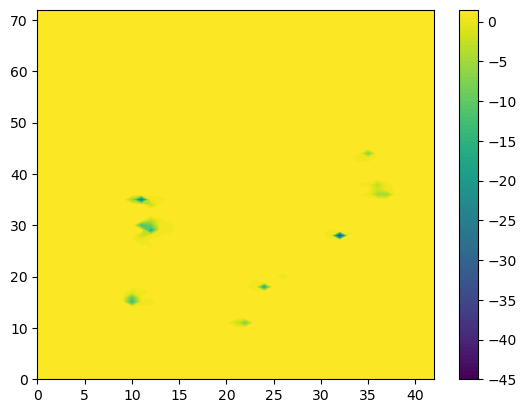

In [13]:
plt.contourf(ds_out_nodiff["xx_c_slide_init"], levels = 100)
plt.colorbar()